In [ ]:
import glob
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, balanced_accuracy_score

from tqdm import tqdm
import time
import numpy as np
from functools import partial

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
import string

nltk.download('stopwords')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

In [ ]:
MAX_WORDS = 25
EPOCHS = 15
LEARNING_RATE = 1e-3
BATCH_SIZE = 32
EMBEDDING_DIM = 100
HIDDEN_DIM = 64
NUM_HEADS = 5

In [ ]:
def create_plots(df):

  sns.set(style="whitegrid")

  plt.figure(figsize=(16, 8))

  plt.subplot(1, 3, 1)
  sns.barplot(x='Dataset', y='Test Accuracy', data=df)
  plt.title('Test Accuracy by Dataset')
  plt.xticks(rotation=90)

  plt.subplot(1, 3, 2)
  sns.barplot(x='Dataset', y='Training Time', data=df)
  plt.title('Training Time by Dataset')
  plt.xticks(rotation=90)

  plt.subplot(1, 3, 3)
  sns.barplot(x='Dataset', y='Parameters', data=df)
  plt.title('Model Parameters by Dataset')
  plt.xticks(rotation=90)

  plt.tight_layout()
  plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

csv_files = glob.glob(os.path.join('/content/drive/MyDrive/Datasets/Deception/', '*.csv'))

dataframes = {}
for file in csv_files:
    df = pd.read_csv(file)
    dataframes.update({os.path.basename(file).split('.')[0]: df})

tokenizer = get_tokenizer("basic_english")
stop_words = set(stopwords.words('english'))

def yield_tokens(data_iter):
    for text in data_iter:
        tokens = tokenizer(text.lower())  # Convert to lowercase
        tokens = [token for token in tokens if token not in stop_words and token not in string.punctuation]  # Remove stopwords and punctuation
        yield tokens

def build_vocabulary(datasets):
    for dataset in datasets:
        for _, text in dataset:
            tokens = tokenizer(text.lower())  # Convert to lowercase
            tokens = [token for token in tokens if token not in stop_words and token not in string.punctuation]  # Remove stopwords and punctuation
            yield tokens


Mounted at /content/drive


In [ ]:
def collate_batch(batch, max_words, vocab):
    Y, X = list(zip(*batch))
    Y = torch.tensor(Y, dtype=torch.long)  # Targets in range [0,1,2,3]
    X = [vocab(tokenizer(text)) for text in X]
    if max_words == -1:
        max_words = max(len(tokens) for tokens in X)
    X = [tokens + ([vocab['<PAD>']] * (max_words - len(tokens))) if len(tokens) < max_words else tokens[:max_words] for tokens in X]
    return torch.tensor(X, dtype=torch.int64).to(device), Y.to(device)

def make_data_loaders(train_dataset, test_dataset, max_words, vocab):
    custom_collate_fn = partial(collate_batch, max_words=max_words, vocab= vocab)

    num_train = int(len(train_dataset) * 0.95)
    split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

    train_loader = DataLoader(split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate_fn)
    valid_loader = DataLoader(split_valid_, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn)

    return [train_loader, valid_loader, test_loader]


### RNN Models

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=input_dim, embedding_dim=embedding_dim)
        self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        output, hidden = self.rnn(embeddings)
        logits = self.linear(output[:, -1, :])
        return logits



class BiRNNModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super(BiRNNModel, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=input_dim, embedding_dim=embedding_dim)
        self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(hidden_dim * 2, output_dim)  # Multiply by 2 for bidirectional

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        output, hidden = self.rnn(embeddings)
        logits = self.linear(output[:, -1, :])  # Use the final output of the RNN for classification
        return logits


class LSTMModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=input_dim, embedding_dim=embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)
        self.hidden_dim = hidden_dim

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        output, (hn, cn) = self.lstm(embeddings)
        logits = self.linear(output[:, -1, :])
        return logits


class GRUModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super(GRUModel, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=input_dim, embedding_dim=embedding_dim)
        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)
        self.hidden_dim = hidden_dim

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        output, hn = self.gru(embeddings)
        logits = self.linear(output[:, -1, :])
        return logits


class RNNModel_PreTrained(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, pretrained_embeddings=None):
        super(RNNModel_PreTrained, self).__init__()

        if pretrained_embeddings is not None:
            self.embedding_layer = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)
        else:
            self.embedding_layer = nn.Embedding(num_embeddings=input_dim, embedding_dim=embedding_dim)

        self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        output, hidden = self.rnn(embeddings)
        logits = self.linear(output[:, -1, :])
        return logits

### Attention Models

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(SelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by the number of heads."
        self.head_dim = embed_dim // num_heads
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.fc_out = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        batch_size, seq_len, embed_dim = x.shape
        # Split the embedding into multiple heads
        queries = self.query(x).view(batch_size, seq_len, self.num_heads, self.head_dim)
        keys = self.key(x).view(batch_size, seq_len, self.num_heads, self.head_dim)
        values = self.value(x).view(batch_size, seq_len, self.num_heads, self.head_dim)

        # Transpose to get dimensions: batch_size, num_heads, seq_len, head_dim
        queries = queries.permute(0, 2, 1, 3)
        keys = keys.permute(0, 2, 1, 3)
        values = values.permute(0, 2, 1, 3)

        # Compute dot product attention scores
        attention_scores = torch.matmul(queries, keys.permute(0, 1, 3, 2)) / np.sqrt(self.head_dim)

        # Apply softmax to get attention weights
        attention_weights = F.softmax(attention_scores, dim=-1)

        # Apply dropout
        attention_weights = F.dropout(attention_weights, p=0.1, training=self.training)

        # Weighted sum of values
        weighted_sum = torch.matmul(attention_weights, values)

        # Transpose and reshape to get output
        weighted_sum = weighted_sum.permute(0, 2, 1, 3).contiguous()
        weighted_sum = weighted_sum.view(batch_size, seq_len, embed_dim)

        # Linear layer to get output
        outputs = self.fc_out(weighted_sum)

        return outputs

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, hidden_dim, output_dim):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.attention = SelfAttention(embed_dim, num_heads)
        self.fc = nn.Linear(embed_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        attention_output = self.attention(embedded)
        hidden = F.relu(self.fc(attention_output))
        output = self.output_layer(hidden[:, -1, :])  # Use only the last hidden state for classification
        return output


In [ ]:
class ImprovedTransformerModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, hidden_dim, output_dim, num_layers=2, dropout=0.3):
        super(ImprovedTransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = nn.Parameter(torch.randn(1, MAX_WORDS, embed_dim))
        self.transformer_layers = nn.ModuleList(
            [SelfAttention(embed_dim, num_heads) for _ in range(num_layers)]
        )
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.layer_norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        embedded = self.embedding(x) + self.positional_encoding[:, :x.size(1), :]
        for attention_layer in self.transformer_layers:
            embedded = self.layer_norm(attention_layer(embedded) + embedded)  # Residual connection
        embedded = self.dropout(embedded)
        hidden = F.relu(self.fc1(embedded))
        output = self.fc2(hidden[:, -1, :])  # Use the last hidden state for classification
        return output


### Train & Evaluation

In [ ]:
def EvaluateModel(model, loss_fn, val_loader):
    model.eval()
    with torch.no_grad():
        Y_actual, Y_preds, losses = [], [], []
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_actual.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_actual = torch.cat(Y_actual)
        Y_preds = torch.cat(Y_preds)

    return torch.tensor(losses).mean(), Y_actual.detach().cpu().numpy(), Y_preds.detach().cpu().numpy()

def TrainModel(model, loss_fn, optimizer, train_loader, valid_loader, epochs, patience):
    best_accuracy = 0.0
    consecutive_no_improvement = 0

    for i in range(1, epochs+1):
        model.train()
        print('Epoch:', i)
        losses = []
        start_time = time.time()
        for X, Y in tqdm(train_loader):
            Y_preds = model(X)
            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_time = time.time() - start_time
        print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
        valid_loss, valid_actual, valid_preds = EvaluateModel(model, loss_fn, valid_loader)
        print("Valid Loss : {:.3f}".format(valid_loss), "Valid Acc  : {:.3f}".format(accuracy_score(valid_actual, valid_preds)))

        accuracy = accuracy_score(valid_actual, valid_preds)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1

        if consecutive_no_improvement >= patience:
            print(f"Early stopping: No improvement for {patience} consecutive epochs.")
            break

    return train_time


def classification_results(classifier, loaders, patience=float('inf')):
    train_loader, valid_loader, test_loader = loaders

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam([param for param in classifier.parameters() if param.requires_grad], lr=LEARNING_RATE)

    def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    print('\nModel:')
    print(classifier)
    print('Total parameters: ', count_parameters(classifier))
    print('\n\n')

    mean_training_time = TrainModel(classifier, loss_fn, optimizer, train_loader, valid_loader, EPOCHS, patience)

    _, Y_actual, Y_preds = EvaluateModel(classifier, loss_fn, test_loader)

    # Calculate accuracy
    accuracy = accuracy_score(Y_actual, Y_preds)

    # Calculate precision, recall, and F1 score
    precision = precision_score(Y_actual, Y_preds, average='weighted')
    recall = recall_score(Y_actual, Y_preds, average='weighted')
    f1 = f1_score(Y_actual, Y_preds, average='weighted')

    # Calculate balanced accuracy
    balanced_acc = balanced_accuracy_score(Y_actual, Y_preds)

    print("\nTest Accuracy : {:.3f}".format(accuracy))
    print("Precision (Weighted): {:.3f}".format(precision))
    print("Recall (Weighted): {:.3f}".format(recall))
    print("F1-Score (Weighted): {:.3f}".format(f1))
    print("Balanced Accuracy: {:.3f}".format(balanced_acc))

    print("\nClassification Report : ")
    print(classification_report(Y_actual, Y_preds, target_names=['0', '1']))
    print("\nConfusion Matrix : ")
    print(confusion_matrix(Y_actual, Y_preds))

    total_params = count_parameters(classifier)
    print(f'{total_params}, {mean_training_time}, {accuracy}')

    return {
        'Dataset': dataset_name,
        'Parameters': total_params,
        'Training Time': mean_training_time,
        'Test Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Balanced Accuracy': balanced_acc
    }



### Run experiments

In [ ]:
def prepare_data_loaders_for_cross_dataset(dataframes, train_datasets, test_datasets):
    # Combine datasets for training
    train_dfs = [dataframes[dname] for dname in train_datasets]
    combined_train_df = pd.concat(train_dfs).reset_index(drop=True)

    # Combine datasets for testing
    test_dfs = [dataframes[dname] for dname in test_datasets]
    combined_test_df = pd.concat(test_dfs).reset_index(drop=True)

    # Preprocess combined training and testing data
    combined_train_df['CLASS'] = combined_train_df['CLASS'].replace({'truthful': 0, 'deceptive': 1})
    combined_test_df['CLASS'] = combined_test_df['CLASS'].replace({'truthful': 0, 'deceptive': 1})

    X_train = combined_train_df['TEXT']
    y_train = combined_train_df['CLASS']

    X_test = combined_test_df['TEXT']
    y_test = combined_test_df['CLASS']

    # Combine train datasets
    train_dataset = [(label, text) for label, text in zip(y_train, X_train)]
    test_dataset = [(label, text) for label, text in zip(y_test, X_test)]

    vocab = build_vocab_from_iterator(build_vocabulary([train_dataset]), min_freq=10, specials=["<PAD>", "<UNK>"])
    vocab.set_default_index(vocab["<UNK>"])

    loaders = make_data_loaders(train_dataset, test_dataset, MAX_WORDS, vocab)

    return loaders, vocab


In [ ]:
datasets_loaders = {}
datasets_list = list(dataframes.keys())
for i in range(len(datasets_list)):
  train = datasets_list[:i] + datasets_list[i+1:]
  print(train)
  test = [datasets_list[i]]
  print(test)
  loader, vocab = prepare_data_loaders_for_cross_dataset(dataframes, train, test)
  datasets_loaders.update({datasets_list[i]: (loader, vocab)})

['Restaurants_Reviews_Dataset', 'DeRev_Dataset', 'Amazon_Reviews_Dataset', 'Cross_Cultural_Dataset']
['OP_Spam_Dataset']
['OP_Spam_Dataset', 'DeRev_Dataset', 'Amazon_Reviews_Dataset', 'Cross_Cultural_Dataset']
['Restaurants_Reviews_Dataset']
['OP_Spam_Dataset', 'Restaurants_Reviews_Dataset', 'Amazon_Reviews_Dataset', 'Cross_Cultural_Dataset']
['DeRev_Dataset']
['OP_Spam_Dataset', 'Restaurants_Reviews_Dataset', 'DeRev_Dataset', 'Cross_Cultural_Dataset']
['Amazon_Reviews_Dataset']
['OP_Spam_Dataset', 'Restaurants_Reviews_Dataset', 'DeRev_Dataset', 'Amazon_Reviews_Dataset']
['Cross_Cultural_Dataset']


In [ ]:
def run_experiment(loaders, model_class, model_name, patience=3, attention=False):
    results_list = []
    for dname, (loaders, vocab) in loaders.items():
        global dataset_name
        dataset_name = dname
        print(vocab)
        if not attention:
            model_instance = model_class(len(vocab), EMBEDDING_DIM, HIDDEN_DIM, 2).to(device)
        else:
            model_instance = model_class(len(vocab), EMBEDDING_DIM, NUM_HEADS, HIDDEN_DIM, 2).to(device)

        results = classification_results(model_instance, loaders, patience)
        results_list.append(results)

    results_df = pd.DataFrame(results_list)
    print(f"\nResults DataFrame for {model_name}:")
    print(results_df)
    create_plots(results_df)
    return results_df

In [ ]:
datasets_loaders

{'OP_Spam_Dataset': ([<torch.utils.data.dataloader.DataLoader at 0x79e08ed83e80>,
  Vocab()),
 'Restaurants_Reviews_Dataset': ([<torch.utils.data.dataloader.DataLoader at 0x79dfa80b9180>,
  Vocab()),
 'DeRev_Dataset': ([<torch.utils.data.dataloader.DataLoader at 0x79dfa7791510>,
  Vocab()),
 'Amazon_Reviews_Dataset': ([<torch.utils.data.dataloader.DataLoader at 0x79dfa7793580>,
  Vocab()),
 'Cross_Cultural_Dataset': ([<torch.utils.data.dataloader.DataLoader at 0x79dfa77937f0>,
  Vocab())}

Vocab()

Model:
RNNModel(
  (embedding_layer): Embedding(7032, 100)
  (rnn): RNN(100, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)
Total parameters:  713954



Epoch: 1


100%|██████████| 652/652 [00:10<00:00, 62.64it/s]


Train Loss : 0.699
Valid Loss : 0.696 Valid Acc  : 0.492
Epoch: 2


100%|██████████| 652/652 [00:09<00:00, 69.04it/s]


Train Loss : 0.687
Valid Loss : 0.699 Valid Acc  : 0.524
Epoch: 3


100%|██████████| 652/652 [00:10<00:00, 62.56it/s]


Train Loss : 0.677
Valid Loss : 0.711 Valid Acc  : 0.523
Epoch: 4


100%|██████████| 652/652 [00:10<00:00, 62.06it/s]


Train Loss : 0.656
Valid Loss : 0.726 Valid Acc  : 0.519
Epoch: 5


100%|██████████| 652/652 [00:08<00:00, 73.01it/s]


Train Loss : 0.627
Valid Loss : 0.746 Valid Acc  : 0.525
Epoch: 6


100%|██████████| 652/652 [00:10<00:00, 62.29it/s]


Train Loss : 0.591
Valid Loss : 0.799 Valid Acc  : 0.524
Epoch: 7


100%|██████████| 652/652 [00:10<00:00, 62.55it/s]


Train Loss : 0.548
Valid Loss : 0.845 Valid Acc  : 0.517
Epoch: 8


100%|██████████| 652/652 [00:09<00:00, 72.23it/s]


Train Loss : 0.505
Valid Loss : 0.942 Valid Acc  : 0.505
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.476
Precision (Weighted): 0.475
Recall (Weighted): 0.476
F1-Score (Weighted): 0.475
Balanced Accuracy: 0.476

Classification Report : 
              precision    recall  f1-score   support

           0       0.48      0.51      0.49       800
           1       0.47      0.44      0.46       800

    accuracy                           0.48      1600
   macro avg       0.48      0.48      0.47      1600
weighted avg       0.48      0.48      0.47      1600


Confusion Matrix : 
[[410 390]
 [449 351]]
713954, 9.03217601776123, 0.475625
Vocab()

Model:
RNNModel(
  (embedding_layer): Embedding(7619, 100)
  (rnn): RNN(100, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)
Total parameters:  772654



Epoch: 1


100%|██████████| 696/696 [00:11<00:00, 58.52it/s]


Train Loss : 0.697
Valid Loss : 0.695 Valid Acc  : 0.529
Epoch: 2


100%|██████████| 696/696 [00:11<00:00, 59.20it/s]


Train Loss : 0.688
Valid Loss : 0.697 Valid Acc  : 0.528
Epoch: 3


100%|██████████| 696/696 [00:11<00:00, 60.41it/s]


Train Loss : 0.678
Valid Loss : 0.706 Valid Acc  : 0.503
Epoch: 4


100%|██████████| 696/696 [00:10<00:00, 66.98it/s]


Train Loss : 0.658
Valid Loss : 0.721 Valid Acc  : 0.523
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.500
Precision (Weighted): 0.500
Recall (Weighted): 0.500
F1-Score (Weighted): 0.500
Balanced Accuracy: 0.500

Classification Report : 
              precision    recall  f1-score   support

           0       0.50      0.49      0.50        55
           1       0.50      0.51      0.50        55

    accuracy                           0.50       110
   macro avg       0.50      0.50      0.50       110
weighted avg       0.50      0.50      0.50       110


Confusion Matrix : 
[[27 28]
 [27 28]]
772654, 10.396361351013184, 0.5
Vocab()

Model:
RNNModel(
  (embedding_layer): Embedding(7471, 100)
  (rnn): RNN(100, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)
Total parameters:  757854



Epoch: 1


100%|██████████| 693/693 [00:11<00:00, 61.43it/s]


Train Loss : 0.699
Valid Loss : 0.689 Valid Acc  : 0.540
Epoch: 2


100%|██████████| 693/693 [00:11<00:00, 60.07it/s]


Train Loss : 0.689
Valid Loss : 0.698 Valid Acc  : 0.495
Epoch: 3


100%|██████████| 693/693 [00:11<00:00, 60.28it/s]


Train Loss : 0.679
Valid Loss : 0.696 Valid Acc  : 0.503
Epoch: 4


100%|██████████| 693/693 [00:10<00:00, 65.23it/s]


Train Loss : 0.659
Valid Loss : 0.709 Valid Acc  : 0.527
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.496
Precision (Weighted): 0.495
Recall (Weighted): 0.496
F1-Score (Weighted): 0.486
Balanced Accuracy: 0.496

Classification Report : 
              precision    recall  f1-score   support

           0       0.50      0.64      0.56       118
           1       0.49      0.36      0.41       118

    accuracy                           0.50       236
   macro avg       0.50      0.50      0.49       236
weighted avg       0.50      0.50      0.49       236


Confusion Matrix : 
[[75 43]
 [76 42]]
757854, 10.6317138671875, 0.4957627118644068
Vocab()

Model:
RNNModel(
  (embedding_layer): Embedding(2230, 100)
  (rnn): RNN(100, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)
Total parameters:  233754



Epoch: 1


100%|██████████| 76/76 [00:01<00:00, 50.91it/s]


Train Loss : 0.701
Valid Loss : 0.702 Valid Acc  : 0.531
Epoch: 2


100%|██████████| 76/76 [00:01<00:00, 65.71it/s]


Train Loss : 0.682
Valid Loss : 0.717 Valid Acc  : 0.516
Epoch: 3


100%|██████████| 76/76 [00:00<00:00, 84.06it/s]


Train Loss : 0.668
Valid Loss : 0.700 Valid Acc  : 0.516
Epoch: 4


100%|██████████| 76/76 [00:00<00:00, 83.74it/s]


Train Loss : 0.627
Valid Loss : 0.738 Valid Acc  : 0.523
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.491
Precision (Weighted): 0.489
Recall (Weighted): 0.491
F1-Score (Weighted): 0.463
Balanced Accuracy: 0.491

Classification Report : 
              precision    recall  f1-score   support

           0       0.49      0.72      0.59     10500
           1       0.48      0.26      0.34     10500

    accuracy                           0.49     21000
   macro avg       0.49      0.49      0.46     21000
weighted avg       0.49      0.49      0.46     21000


Confusion Matrix : 
[[7563 2937]
 [7745 2755]]
233754, 0.9171750545501709, 0.49133333333333334
Vocab()

Model:
RNNModel(
  (embedding_layer): Embedding(7519, 100)
  (rnn): RNN(100, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)
Total parameters:  762654



Epoch: 1


100%|██████████| 682/682 [00:11<00:00, 57.86it/s]


Train Loss : 0.697
Valid Loss : 0.697 Valid Acc  : 0.493
Epoch: 2


100%|██████████| 682/682 [00:10<00:00, 64.08it/s]


Train Loss : 0.689
Valid Loss : 0.698 Valid Acc  : 0.510
Epoch: 3


100%|██████████| 682/682 [00:10<00:00, 64.01it/s]


Train Loss : 0.679
Valid Loss : 0.700 Valid Acc  : 0.515
Epoch: 4


100%|██████████| 682/682 [00:11<00:00, 60.61it/s]


Train Loss : 0.657
Valid Loss : 0.715 Valid Acc  : 0.508
Epoch: 5


100%|██████████| 682/682 [00:11<00:00, 61.54it/s]


Train Loss : 0.622
Valid Loss : 0.745 Valid Acc  : 0.520
Epoch: 6


100%|██████████| 682/682 [00:10<00:00, 64.77it/s]


Train Loss : 0.577
Valid Loss : 0.771 Valid Acc  : 0.520
Epoch: 7


100%|██████████| 682/682 [00:10<00:00, 65.52it/s]


Train Loss : 0.529
Valid Loss : 0.884 Valid Acc  : 0.517
Epoch: 8


100%|██████████| 682/682 [00:11<00:00, 61.43it/s]


Train Loss : 0.481
Valid Loss : 0.918 Valid Acc  : 0.515
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.507
Precision (Weighted): 0.507
Recall (Weighted): 0.507
F1-Score (Weighted): 0.505
Balanced Accuracy: 0.506

Classification Report : 
              precision    recall  f1-score   support

           0       0.51      0.45      0.47       301
           1       0.51      0.57      0.54       303

    accuracy                           0.51       604
   macro avg       0.51      0.51      0.50       604
weighted avg       0.51      0.51      0.50       604


Confusion Matrix : 
[[134 167]
 [131 172]]
762654, 11.108831644058228, 0.5066225165562914

Results DataFrame for RNN Model:
                       Dataset  Parameters  Training Time  Test Accuracy  \
0              OP_Spam_Dataset      713954       9.032176       0.475625   
1  Restaurants_Reviews_Dataset      772654      10.396361       0.500000   
2                DeRev_Dataset      757854      10.6

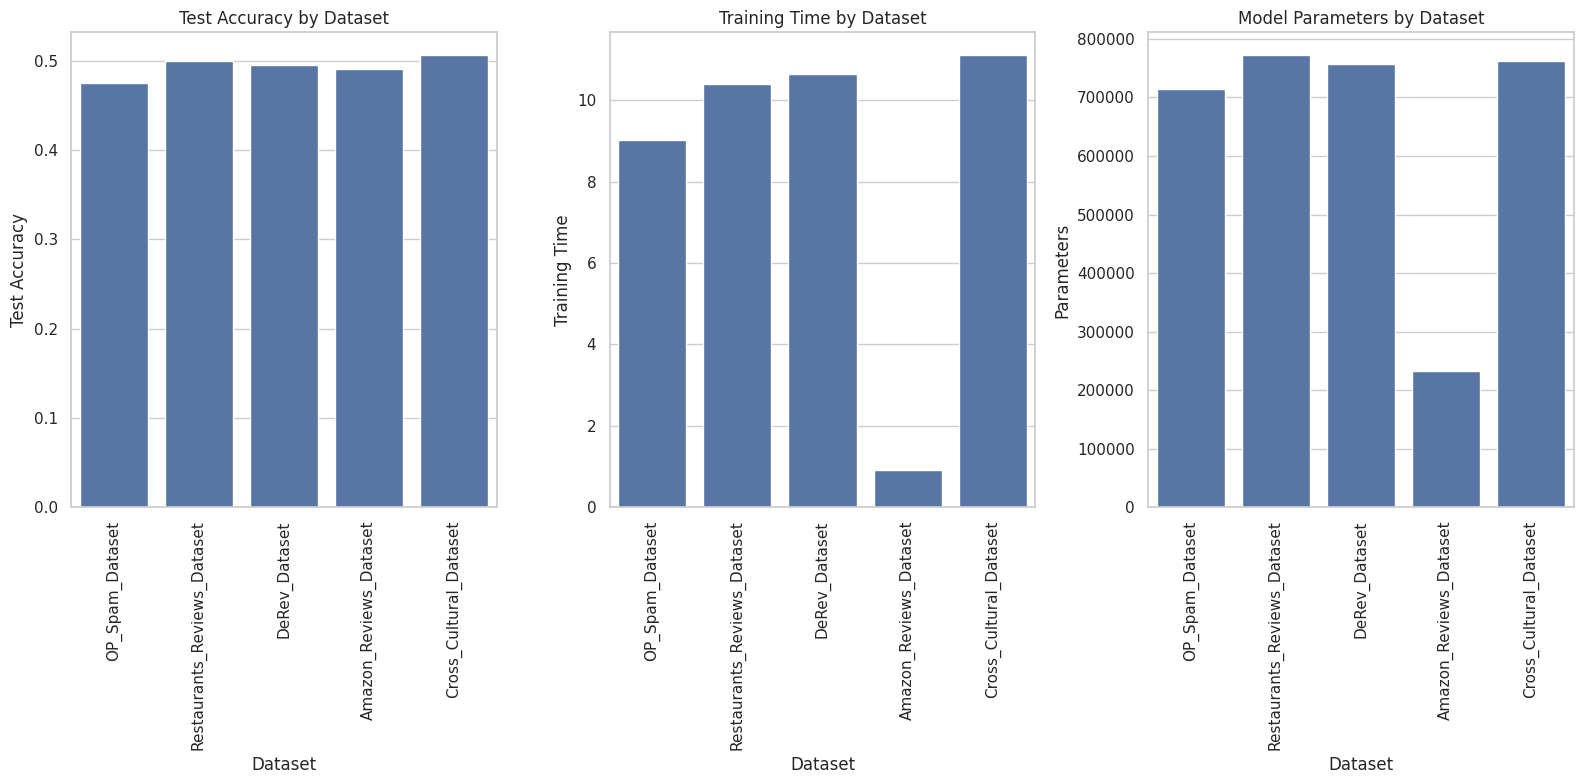

In [ ]:
rnn_results_df = run_experiment(datasets_loaders, RNNModel, "RNN Model", 3, False)

Vocab()

Model:
BiRNNModel(
  (embedding_layer): Embedding(7032, 100)
  (rnn): RNN(100, 64, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=128, out_features=2, bias=True)
)
Total parameters:  724706



Epoch: 1


100%|██████████| 652/652 [00:15<00:00, 42.20it/s]


Train Loss : 0.700
Valid Loss : 0.698 Valid Acc  : 0.510
Epoch: 2


100%|██████████| 652/652 [00:14<00:00, 45.75it/s]


Train Loss : 0.690
Valid Loss : 0.698 Valid Acc  : 0.513
Epoch: 3


100%|██████████| 652/652 [00:14<00:00, 46.22it/s]


Train Loss : 0.679
Valid Loss : 0.710 Valid Acc  : 0.522
Epoch: 4


100%|██████████| 652/652 [00:14<00:00, 45.80it/s]


Train Loss : 0.658
Valid Loss : 0.727 Valid Acc  : 0.517
Epoch: 5


100%|██████████| 652/652 [00:14<00:00, 46.37it/s]


Train Loss : 0.628
Valid Loss : 0.756 Valid Acc  : 0.510
Epoch: 6


100%|██████████| 652/652 [00:14<00:00, 46.37it/s]


Train Loss : 0.590
Valid Loss : 0.773 Valid Acc  : 0.529
Epoch: 7


100%|██████████| 652/652 [00:14<00:00, 46.53it/s]


Train Loss : 0.547
Valid Loss : 0.827 Valid Acc  : 0.516
Epoch: 8


100%|██████████| 652/652 [00:14<00:00, 46.54it/s]


Train Loss : 0.502
Valid Loss : 0.881 Valid Acc  : 0.549
Epoch: 9


100%|██████████| 652/652 [00:13<00:00, 47.13it/s]


Train Loss : 0.452
Valid Loss : 0.945 Valid Acc  : 0.522
Epoch: 10


100%|██████████| 652/652 [00:14<00:00, 46.22it/s]


Train Loss : 0.405
Valid Loss : 0.987 Valid Acc  : 0.531
Epoch: 11


100%|██████████| 652/652 [00:14<00:00, 46.16it/s]


Train Loss : 0.355
Valid Loss : 1.085 Valid Acc  : 0.539
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.478
Precision (Weighted): 0.478
Recall (Weighted): 0.478
F1-Score (Weighted): 0.478
Balanced Accuracy: 0.478

Classification Report : 
              precision    recall  f1-score   support

           0       0.48      0.50      0.49       800
           1       0.48      0.45      0.46       800

    accuracy                           0.48      1600
   macro avg       0.48      0.48      0.48      1600
weighted avg       0.48      0.48      0.48      1600


Confusion Matrix : 
[[403 397]
 [438 362]]
724706, 14.134168863296509, 0.478125
Vocab()

Model:
BiRNNModel(
  (embedding_layer): Embedding(7619, 100)
  (rnn): RNN(100, 64, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=128, out_features=2, bias=True)
)
Total parameters:  783406



Epoch: 1


100%|██████████| 696/696 [00:15<00:00, 44.23it/s]


Train Loss : 0.699
Valid Loss : 0.695 Valid Acc  : 0.521
Epoch: 2


100%|██████████| 696/696 [00:15<00:00, 45.36it/s]


Train Loss : 0.690
Valid Loss : 0.694 Valid Acc  : 0.509
Epoch: 3


100%|██████████| 696/696 [00:15<00:00, 44.56it/s]


Train Loss : 0.681
Valid Loss : 0.711 Valid Acc  : 0.512
Epoch: 4


100%|██████████| 696/696 [00:15<00:00, 45.30it/s]


Train Loss : 0.660
Valid Loss : 0.719 Valid Acc  : 0.515
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.445
Precision (Weighted): 0.434
Recall (Weighted): 0.445
F1-Score (Weighted): 0.420
Balanced Accuracy: 0.445

Classification Report : 
              precision    recall  f1-score   support

           0       0.41      0.24      0.30        55
           1       0.46      0.65      0.54        55

    accuracy                           0.45       110
   macro avg       0.43      0.45      0.42       110
weighted avg       0.43      0.45      0.42       110


Confusion Matrix : 
[[13 42]
 [19 36]]
783406, 15.373576641082764, 0.44545454545454544
Vocab()

Model:
BiRNNModel(
  (embedding_layer): Embedding(7471, 100)
  (rnn): RNN(100, 64, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=128, out_features=2, bias=True)
)
Total parameters:  768606



Epoch: 1


100%|██████████| 693/693 [00:15<00:00, 43.64it/s]


Train Loss : 0.699
Valid Loss : 0.691 Valid Acc  : 0.506
Epoch: 2


100%|██████████| 693/693 [00:15<00:00, 44.42it/s]


Train Loss : 0.690
Valid Loss : 0.696 Valid Acc  : 0.504
Epoch: 3


100%|██████████| 693/693 [00:15<00:00, 43.61it/s]


Train Loss : 0.678
Valid Loss : 0.695 Valid Acc  : 0.528
Epoch: 4


100%|██████████| 693/693 [00:15<00:00, 43.61it/s]


Train Loss : 0.656
Valid Loss : 0.719 Valid Acc  : 0.521
Epoch: 5


100%|██████████| 693/693 [00:16<00:00, 43.20it/s]


Train Loss : 0.623
Valid Loss : 0.741 Valid Acc  : 0.533
Epoch: 6


100%|██████████| 693/693 [00:15<00:00, 43.74it/s]


Train Loss : 0.582
Valid Loss : 0.785 Valid Acc  : 0.533
Epoch: 7


100%|██████████| 693/693 [00:16<00:00, 42.98it/s]


Train Loss : 0.535
Valid Loss : 0.813 Valid Acc  : 0.534
Epoch: 8


100%|██████████| 693/693 [00:16<00:00, 42.58it/s]


Train Loss : 0.486
Valid Loss : 0.903 Valid Acc  : 0.548
Epoch: 9


100%|██████████| 693/693 [00:15<00:00, 43.80it/s]


Train Loss : 0.433
Valid Loss : 0.922 Valid Acc  : 0.531
Epoch: 10


100%|██████████| 693/693 [00:15<00:00, 44.84it/s]


Train Loss : 0.382
Valid Loss : 1.077 Valid Acc  : 0.538
Epoch: 11


100%|██████████| 693/693 [00:15<00:00, 43.77it/s]


Train Loss : 0.330
Valid Loss : 1.184 Valid Acc  : 0.538
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.564
Precision (Weighted): 0.564
Recall (Weighted): 0.564
F1-Score (Weighted): 0.562
Balanced Accuracy: 0.564

Classification Report : 
              precision    recall  f1-score   support

           0       0.57      0.51      0.54       118
           1       0.56      0.62      0.59       118

    accuracy                           0.56       236
   macro avg       0.56      0.56      0.56       236
weighted avg       0.56      0.56      0.56       236


Confusion Matrix : 
[[60 58]
 [45 73]]
768606, 15.837421417236328, 0.5635593220338984
Vocab()

Model:
BiRNNModel(
  (embedding_layer): Embedding(2230, 100)
  (rnn): RNN(100, 64, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=128, out_features=2, bias=True)
)
Total parameters:  244506



Epoch: 1


100%|██████████| 76/76 [00:01<00:00, 57.61it/s]


Train Loss : 0.710
Valid Loss : 0.704 Valid Acc  : 0.508
Epoch: 2


100%|██████████| 76/76 [00:01<00:00, 58.21it/s]


Train Loss : 0.676
Valid Loss : 0.715 Valid Acc  : 0.531
Epoch: 3


100%|██████████| 76/76 [00:01<00:00, 56.85it/s]


Train Loss : 0.644
Valid Loss : 0.742 Valid Acc  : 0.508
Epoch: 4


100%|██████████| 76/76 [00:01<00:00, 58.24it/s]


Train Loss : 0.610
Valid Loss : 0.775 Valid Acc  : 0.508
Epoch: 5


100%|██████████| 76/76 [00:01<00:00, 41.08it/s]


Train Loss : 0.555
Valid Loss : 0.837 Valid Acc  : 0.523
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.496
Precision (Weighted): 0.496
Recall (Weighted): 0.496
F1-Score (Weighted): 0.495
Balanced Accuracy: 0.496

Classification Report : 
              precision    recall  f1-score   support

           0       0.50      0.55      0.52     10500
           1       0.50      0.44      0.47     10500

    accuracy                           0.50     21000
   macro avg       0.50      0.50      0.49     21000
weighted avg       0.50      0.50      0.49     21000


Confusion Matrix : 
[[5826 4674]
 [5900 4600]]
244506, 1.8575260639190674, 0.49647619047619046
Vocab()

Model:
BiRNNModel(
  (embedding_layer): Embedding(7519, 100)
  (rnn): RNN(100, 64, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=128, out_features=2, bias=True)
)
Total parameters:  773406



Epoch: 1


100%|██████████| 682/682 [00:15<00:00, 44.69it/s]


Train Loss : 0.700
Valid Loss : 0.691 Valid Acc  : 0.510
Epoch: 2


100%|██████████| 682/682 [00:15<00:00, 45.36it/s]


Train Loss : 0.690
Valid Loss : 0.695 Valid Acc  : 0.522
Epoch: 3


100%|██████████| 682/682 [00:15<00:00, 45.46it/s]


Train Loss : 0.680
Valid Loss : 0.691 Valid Acc  : 0.531
Epoch: 4


100%|██████████| 682/682 [00:14<00:00, 46.20it/s]


Train Loss : 0.659
Valid Loss : 0.724 Valid Acc  : 0.533
Epoch: 5


100%|██████████| 682/682 [00:14<00:00, 45.65it/s]


Train Loss : 0.623
Valid Loss : 0.729 Valid Acc  : 0.531
Epoch: 6


100%|██████████| 682/682 [00:14<00:00, 46.37it/s]


Train Loss : 0.580
Valid Loss : 0.774 Valid Acc  : 0.538
Epoch: 7


100%|██████████| 682/682 [00:14<00:00, 45.78it/s]


Train Loss : 0.534
Valid Loss : 0.802 Valid Acc  : 0.520
Epoch: 8


100%|██████████| 682/682 [00:14<00:00, 45.62it/s]


Train Loss : 0.484
Valid Loss : 0.862 Valid Acc  : 0.518
Epoch: 9


100%|██████████| 682/682 [00:15<00:00, 45.46it/s]


Train Loss : 0.431
Valid Loss : 0.928 Valid Acc  : 0.524
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.518
Precision (Weighted): 0.518
Recall (Weighted): 0.518
F1-Score (Weighted): 0.517
Balanced Accuracy: 0.518

Classification Report : 
              precision    recall  f1-score   support

           0       0.52      0.47      0.49       301
           1       0.52      0.57      0.54       303

    accuracy                           0.52       604
   macro avg       0.52      0.52      0.52       604
weighted avg       0.52      0.52      0.52       604


Confusion Matrix : 
[[141 160]
 [131 172]]
773406, 15.012075424194336, 0.5182119205298014

Results DataFrame for BiRNN Model:
                       Dataset  Parameters  Training Time  Test Accuracy  \
0              OP_Spam_Dataset      724706      14.134169       0.478125   
1  Restaurants_Reviews_Dataset      783406      15.373577       0.445455   
2                DeRev_Dataset      768606      15

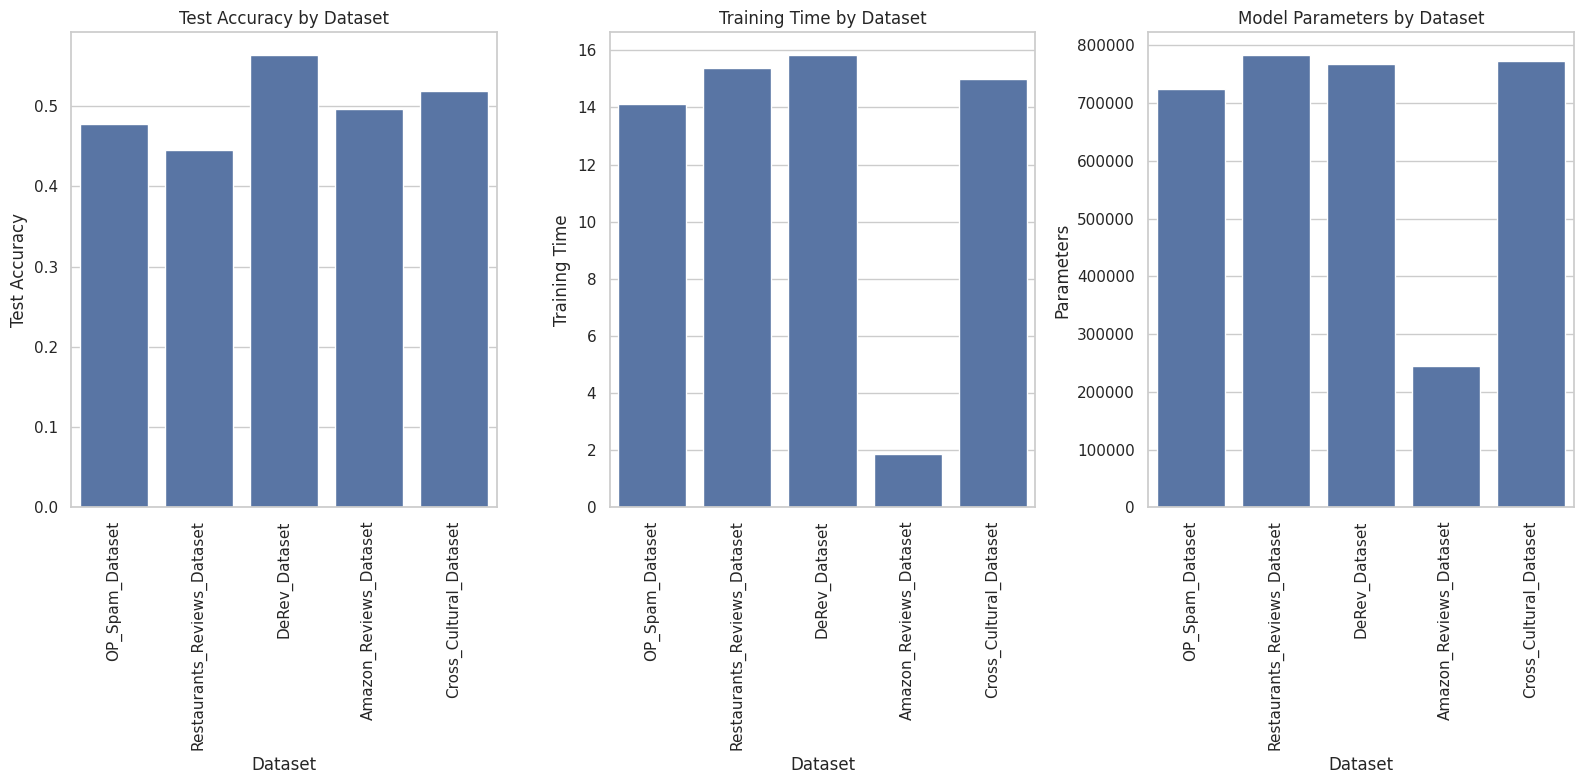

Vocab()

Model:
LSTMModel(
  (embedding_layer): Embedding(7032, 100)
  (lstm): LSTM(100, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)
Total parameters:  745826



Epoch: 1


100%|██████████| 652/652 [00:13<00:00, 47.86it/s]


Train Loss : 0.691
Valid Loss : 0.690 Valid Acc  : 0.528
Epoch: 2


100%|██████████| 652/652 [00:13<00:00, 48.60it/s]


Train Loss : 0.663
Valid Loss : 0.688 Valid Acc  : 0.570
Epoch: 3


100%|██████████| 652/652 [00:13<00:00, 49.13it/s]


Train Loss : 0.605
Valid Loss : 0.703 Valid Acc  : 0.577
Epoch: 4


100%|██████████| 652/652 [00:13<00:00, 49.34it/s]


Train Loss : 0.533
Valid Loss : 0.769 Valid Acc  : 0.571
Epoch: 5


100%|██████████| 652/652 [00:12<00:00, 50.38it/s]


Train Loss : 0.450
Valid Loss : 0.819 Valid Acc  : 0.577
Epoch: 6


100%|██████████| 652/652 [00:12<00:00, 52.00it/s]


Train Loss : 0.359
Valid Loss : 0.984 Valid Acc  : 0.590
Epoch: 7


100%|██████████| 652/652 [00:12<00:00, 51.46it/s]


Train Loss : 0.272
Valid Loss : 1.125 Valid Acc  : 0.574
Epoch: 8


100%|██████████| 652/652 [00:13<00:00, 48.79it/s]


Train Loss : 0.188
Valid Loss : 1.370 Valid Acc  : 0.569
Epoch: 9


100%|██████████| 652/652 [00:13<00:00, 48.98it/s]


Train Loss : 0.124
Valid Loss : 1.674 Valid Acc  : 0.566
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.539
Precision (Weighted): 0.540
Recall (Weighted): 0.539
F1-Score (Weighted): 0.536
Balanced Accuracy: 0.539

Classification Report : 
              precision    recall  f1-score   support

           0       0.55      0.46      0.50       800
           1       0.53      0.62      0.57       800

    accuracy                           0.54      1600
   macro avg       0.54      0.54      0.54      1600
weighted avg       0.54      0.54      0.54      1600


Confusion Matrix : 
[[368 432]
 [306 494]]
745826, 13.318456172943115, 0.53875
Vocab()

Model:
LSTMModel(
  (embedding_layer): Embedding(7619, 100)
  (lstm): LSTM(100, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)
Total parameters:  804526



Epoch: 1


100%|██████████| 696/696 [00:14<00:00, 48.10it/s]


Train Loss : 0.692
Valid Loss : 0.689 Valid Acc  : 0.535
Epoch: 2


100%|██████████| 696/696 [00:14<00:00, 49.32it/s]


Train Loss : 0.668
Valid Loss : 0.668 Valid Acc  : 0.589
Epoch: 3


100%|██████████| 696/696 [00:14<00:00, 49.25it/s]


Train Loss : 0.608
Valid Loss : 0.679 Valid Acc  : 0.593
Epoch: 4


100%|██████████| 696/696 [00:14<00:00, 49.39it/s]


Train Loss : 0.535
Valid Loss : 0.714 Valid Acc  : 0.596
Epoch: 5


100%|██████████| 696/696 [00:14<00:00, 49.10it/s]


Train Loss : 0.452
Valid Loss : 0.795 Valid Acc  : 0.588
Epoch: 6


100%|██████████| 696/696 [00:14<00:00, 49.69it/s]


Train Loss : 0.362
Valid Loss : 0.971 Valid Acc  : 0.588
Epoch: 7


100%|██████████| 696/696 [00:14<00:00, 49.68it/s]


Train Loss : 0.276
Valid Loss : 1.212 Valid Acc  : 0.588
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.427
Precision (Weighted): 0.424
Recall (Weighted): 0.427
F1-Score (Weighted): 0.421
Balanced Accuracy: 0.427

Classification Report : 
              precision    recall  f1-score   support

           0       0.41      0.33      0.36        55
           1       0.44      0.53      0.48        55

    accuracy                           0.43       110
   macro avg       0.42      0.43      0.42       110
weighted avg       0.42      0.43      0.42       110


Confusion Matrix : 
[[18 37]
 [26 29]]
804526, 14.016703367233276, 0.42727272727272725
Vocab()

Model:
LSTMModel(
  (embedding_layer): Embedding(7471, 100)
  (lstm): LSTM(100, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)
Total parameters:  789726



Epoch: 1


100%|██████████| 693/693 [00:14<00:00, 48.56it/s]


Train Loss : 0.691
Valid Loss : 0.681 Valid Acc  : 0.561
Epoch: 2


100%|██████████| 693/693 [00:13<00:00, 50.17it/s]


Train Loss : 0.658
Valid Loss : 0.664 Valid Acc  : 0.599
Epoch: 3


100%|██████████| 693/693 [00:13<00:00, 50.02it/s]


Train Loss : 0.600
Valid Loss : 0.668 Valid Acc  : 0.598
Epoch: 4


100%|██████████| 693/693 [00:13<00:00, 51.95it/s]


Train Loss : 0.529
Valid Loss : 0.710 Valid Acc  : 0.598
Epoch: 5


100%|██████████| 693/693 [00:13<00:00, 51.14it/s]


Train Loss : 0.449
Valid Loss : 0.778 Valid Acc  : 0.611
Epoch: 6


100%|██████████| 693/693 [00:13<00:00, 51.31it/s]


Train Loss : 0.365
Valid Loss : 0.862 Valid Acc  : 0.594
Epoch: 7


100%|██████████| 693/693 [00:13<00:00, 51.70it/s]


Train Loss : 0.280
Valid Loss : 1.010 Valid Acc  : 0.602
Epoch: 8


100%|██████████| 693/693 [00:13<00:00, 51.17it/s]


Train Loss : 0.200
Valid Loss : 1.175 Valid Acc  : 0.592
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.576
Precision (Weighted): 0.576
Recall (Weighted): 0.576
F1-Score (Weighted): 0.576
Balanced Accuracy: 0.576

Classification Report : 
              precision    recall  f1-score   support

           0       0.57      0.59      0.58       118
           1       0.58      0.56      0.57       118

    accuracy                           0.58       236
   macro avg       0.58      0.58      0.58       236
weighted avg       0.58      0.58      0.58       236


Confusion Matrix : 
[[70 48]
 [52 66]]
789726, 13.549537181854248, 0.576271186440678
Vocab()

Model:
LSTMModel(
  (embedding_layer): Embedding(2230, 100)
  (lstm): LSTM(100, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)
Total parameters:  265626



Epoch: 1


100%|██████████| 76/76 [00:01<00:00, 41.30it/s]


Train Loss : 0.696
Valid Loss : 0.694 Valid Acc  : 0.477
Epoch: 2


100%|██████████| 76/76 [00:01<00:00, 40.70it/s]


Train Loss : 0.683
Valid Loss : 0.699 Valid Acc  : 0.523
Epoch: 3


100%|██████████| 76/76 [00:01<00:00, 64.05it/s]


Train Loss : 0.617
Valid Loss : 0.676 Valid Acc  : 0.586
Epoch: 4


100%|██████████| 76/76 [00:01<00:00, 60.51it/s]


Train Loss : 0.510
Valid Loss : 0.683 Valid Acc  : 0.664
Epoch: 5


100%|██████████| 76/76 [00:01<00:00, 62.09it/s]


Train Loss : 0.410
Valid Loss : 0.674 Valid Acc  : 0.648
Epoch: 6


100%|██████████| 76/76 [00:01<00:00, 63.13it/s]


Train Loss : 0.315
Valid Loss : 0.744 Valid Acc  : 0.672
Epoch: 7


100%|██████████| 76/76 [00:01<00:00, 63.21it/s]


Train Loss : 0.219
Valid Loss : 0.904 Valid Acc  : 0.641
Epoch: 8


100%|██████████| 76/76 [00:01<00:00, 62.26it/s]


Train Loss : 0.135
Valid Loss : 1.034 Valid Acc  : 0.672
Epoch: 9


100%|██████████| 76/76 [00:01<00:00, 63.37it/s]


Train Loss : 0.091
Valid Loss : 1.084 Valid Acc  : 0.609
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.509
Precision (Weighted): 0.509
Recall (Weighted): 0.509
F1-Score (Weighted): 0.504
Balanced Accuracy: 0.509

Classification Report : 
              precision    recall  f1-score   support

           0       0.51      0.61      0.55     10500
           1       0.51      0.41      0.45     10500

    accuracy                           0.51     21000
   macro avg       0.51      0.51      0.50     21000
weighted avg       0.51      0.51      0.50     21000


Confusion Matrix : 
[[6382 4118]
 [6199 4301]]
265626, 1.2053685188293457, 0.5087142857142857
Vocab()

Model:
LSTMModel(
  (embedding_layer): Embedding(7519, 100)
  (lstm): LSTM(100, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)
Total parameters:  794526



Epoch: 1


100%|██████████| 682/682 [00:13<00:00, 50.42it/s]


Train Loss : 0.692
Valid Loss : 0.692 Valid Acc  : 0.523
Epoch: 2


100%|██████████| 682/682 [00:13<00:00, 51.00it/s]


Train Loss : 0.674
Valid Loss : 0.680 Valid Acc  : 0.558
Epoch: 3


100%|██████████| 682/682 [00:13<00:00, 49.99it/s]


Train Loss : 0.618
Valid Loss : 0.688 Valid Acc  : 0.577
Epoch: 4


100%|██████████| 682/682 [00:13<00:00, 50.22it/s]


Train Loss : 0.550
Valid Loss : 0.738 Valid Acc  : 0.578
Epoch: 5


100%|██████████| 682/682 [00:14<00:00, 48.40it/s]


Train Loss : 0.471
Valid Loss : 0.823 Valid Acc  : 0.572
Epoch: 6


100%|██████████| 682/682 [00:14<00:00, 48.29it/s]


Train Loss : 0.386
Valid Loss : 0.962 Valid Acc  : 0.568
Epoch: 7


100%|██████████| 682/682 [00:14<00:00, 48.58it/s]


Train Loss : 0.299
Valid Loss : 1.097 Valid Acc  : 0.567
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.508
Precision (Weighted): 0.508
Recall (Weighted): 0.508
F1-Score (Weighted): 0.506
Balanced Accuracy: 0.508

Classification Report : 
              precision    recall  f1-score   support

           0       0.51      0.45      0.47       301
           1       0.51      0.57      0.54       303

    accuracy                           0.51       604
   macro avg       0.51      0.51      0.51       604
weighted avg       0.51      0.51      0.51       604


Confusion Matrix : 
[[134 167]
 [130 173]]
794526, 14.046451568603516, 0.5082781456953642

Results DataFrame for LSTM Model:
                       Dataset  Parameters  Training Time  Test Accuracy  \
0              OP_Spam_Dataset      745826      13.318456       0.538750   
1  Restaurants_Reviews_Dataset      804526      14.016703       0.427273   
2                DeRev_Dataset      789726      13.

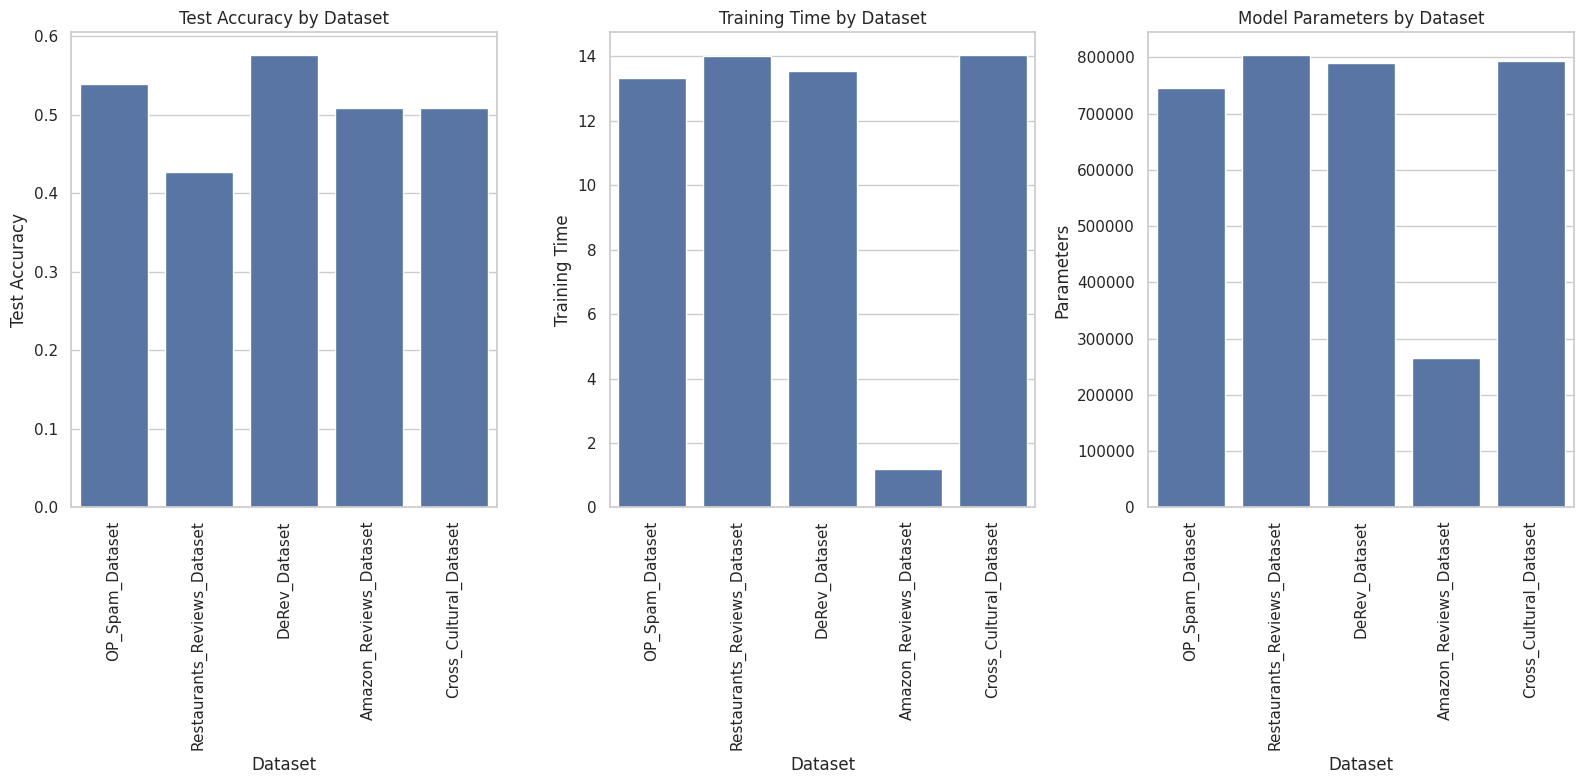

Vocab()

Model:
GRUModel(
  (embedding_layer): Embedding(7032, 100)
  (gru): GRU(100, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)
Total parameters:  735202



Epoch: 1


100%|██████████| 652/652 [00:17<00:00, 37.96it/s]


Train Loss : 0.694
Valid Loss : 0.689 Valid Acc  : 0.531
Epoch: 2


100%|██████████| 652/652 [00:17<00:00, 37.03it/s]


Train Loss : 0.663
Valid Loss : 0.674 Valid Acc  : 0.588
Epoch: 3


100%|██████████| 652/652 [00:17<00:00, 37.46it/s]


Train Loss : 0.608
Valid Loss : 0.698 Valid Acc  : 0.579
Epoch: 4


100%|██████████| 652/652 [00:16<00:00, 38.73it/s]


Train Loss : 0.536
Valid Loss : 0.759 Valid Acc  : 0.587
Epoch: 5


100%|██████████| 652/652 [00:16<00:00, 38.57it/s]


Train Loss : 0.438
Valid Loss : 0.871 Valid Acc  : 0.586
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.606
Precision (Weighted): 0.613
Recall (Weighted): 0.606
F1-Score (Weighted): 0.599
Balanced Accuracy: 0.606

Classification Report : 
              precision    recall  f1-score   support

           0       0.64      0.48      0.55       800
           1       0.58      0.73      0.65       800

    accuracy                           0.61      1600
   macro avg       0.61      0.61      0.60      1600
weighted avg       0.61      0.61      0.60      1600


Confusion Matrix : 
[[383 417]
 [214 586]]
735202, 16.910062074661255, 0.605625
Vocab()

Model:
GRUModel(
  (embedding_layer): Embedding(7619, 100)
  (gru): GRU(100, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)
Total parameters:  793902



Epoch: 1


100%|██████████| 696/696 [00:18<00:00, 37.37it/s]


Train Loss : 0.693
Valid Loss : 0.689 Valid Acc  : 0.543
Epoch: 2


100%|██████████| 696/696 [00:18<00:00, 37.54it/s]


Train Loss : 0.655
Valid Loss : 0.670 Valid Acc  : 0.582
Epoch: 3


100%|██████████| 696/696 [00:19<00:00, 35.80it/s]


Train Loss : 0.594
Valid Loss : 0.688 Valid Acc  : 0.597
Epoch: 4


100%|██████████| 696/696 [00:18<00:00, 38.12it/s]


Train Loss : 0.517
Valid Loss : 0.738 Valid Acc  : 0.601
Epoch: 5


100%|██████████| 696/696 [00:18<00:00, 38.03it/s]


Train Loss : 0.417
Valid Loss : 0.835 Valid Acc  : 0.601
Epoch: 6


100%|██████████| 696/696 [00:18<00:00, 38.20it/s]


Train Loss : 0.305
Valid Loss : 0.982 Valid Acc  : 0.603
Epoch: 7


100%|██████████| 696/696 [00:19<00:00, 36.55it/s]


Train Loss : 0.191
Valid Loss : 1.268 Valid Acc  : 0.601
Epoch: 8


100%|██████████| 696/696 [00:19<00:00, 36.61it/s]


Train Loss : 0.100
Valid Loss : 1.708 Valid Acc  : 0.579
Epoch: 9


100%|██████████| 696/696 [00:18<00:00, 37.63it/s]


Train Loss : 0.053
Valid Loss : 1.927 Valid Acc  : 0.575
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.409
Precision (Weighted): 0.409
Recall (Weighted): 0.409
F1-Score (Weighted): 0.409
Balanced Accuracy: 0.409

Classification Report : 
              precision    recall  f1-score   support

           0       0.41      0.42      0.41        55
           1       0.41      0.40      0.40        55

    accuracy                           0.41       110
   macro avg       0.41      0.41      0.41       110
weighted avg       0.41      0.41      0.41       110


Confusion Matrix : 
[[23 32]
 [33 22]]
793902, 18.506319284439087, 0.4090909090909091
Vocab()

Model:
GRUModel(
  (embedding_layer): Embedding(7471, 100)
  (gru): GRU(100, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)
Total parameters:  779102



Epoch: 1


100%|██████████| 693/693 [00:18<00:00, 37.41it/s]


Train Loss : 0.693
Valid Loss : 0.682 Valid Acc  : 0.559
Epoch: 2


100%|██████████| 693/693 [00:18<00:00, 37.06it/s]


Train Loss : 0.657
Valid Loss : 0.658 Valid Acc  : 0.604
Epoch: 3


100%|██████████| 693/693 [00:19<00:00, 35.95it/s]


Train Loss : 0.597
Valid Loss : 0.677 Valid Acc  : 0.611
Epoch: 4


100%|██████████| 693/693 [00:18<00:00, 37.91it/s]


Train Loss : 0.521
Valid Loss : 0.730 Valid Acc  : 0.602
Epoch: 5


100%|██████████| 693/693 [00:18<00:00, 36.88it/s]


Train Loss : 0.420
Valid Loss : 0.843 Valid Acc  : 0.587
Epoch: 6


100%|██████████| 693/693 [00:18<00:00, 36.85it/s]


Train Loss : 0.300
Valid Loss : 1.047 Valid Acc  : 0.583
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.564
Precision (Weighted): 0.565
Recall (Weighted): 0.564
F1-Score (Weighted): 0.561
Balanced Accuracy: 0.564

Classification Report : 
              precision    recall  f1-score   support

           0       0.56      0.64      0.59       118
           1       0.57      0.49      0.53       118

    accuracy                           0.56       236
   macro avg       0.56      0.56      0.56       236
weighted avg       0.56      0.56      0.56       236


Confusion Matrix : 
[[75 43]
 [60 58]]
779102, 18.814589977264404, 0.5635593220338984
Vocab()

Model:
GRUModel(
  (embedding_layer): Embedding(2230, 100)
  (gru): GRU(100, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)
Total parameters:  255002



Epoch: 1


100%|██████████| 76/76 [00:02<00:00, 30.31it/s]


Train Loss : 0.699
Valid Loss : 0.703 Valid Acc  : 0.492
Epoch: 2


100%|██████████| 76/76 [00:02<00:00, 35.65it/s]


Train Loss : 0.666
Valid Loss : 0.703 Valid Acc  : 0.516
Epoch: 3


100%|██████████| 76/76 [00:01<00:00, 45.60it/s]


Train Loss : 0.581
Valid Loss : 0.666 Valid Acc  : 0.602
Epoch: 4


100%|██████████| 76/76 [00:01<00:00, 45.16it/s]


Train Loss : 0.472
Valid Loss : 0.711 Valid Acc  : 0.641
Epoch: 5


100%|██████████| 76/76 [00:01<00:00, 45.61it/s]


Train Loss : 0.373
Valid Loss : 0.756 Valid Acc  : 0.695
Epoch: 6


100%|██████████| 76/76 [00:01<00:00, 45.44it/s]


Train Loss : 0.275
Valid Loss : 0.859 Valid Acc  : 0.664
Epoch: 7


100%|██████████| 76/76 [00:01<00:00, 44.25it/s]


Train Loss : 0.189
Valid Loss : 0.957 Valid Acc  : 0.664
Epoch: 8


100%|██████████| 76/76 [00:02<00:00, 34.15it/s]


Train Loss : 0.110
Valid Loss : 1.148 Valid Acc  : 0.641
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.513
Precision (Weighted): 0.513
Recall (Weighted): 0.513
F1-Score (Weighted): 0.511
Balanced Accuracy: 0.513

Classification Report : 
              precision    recall  f1-score   support

           0       0.51      0.56      0.53     10500
           1       0.51      0.47      0.49     10500

    accuracy                           0.51     21000
   macro avg       0.51      0.51      0.51     21000
weighted avg       0.51      0.51      0.51     21000


Confusion Matrix : 
[[5878 4622]
 [5615 4885]]
255002, 2.2453601360321045, 0.5125238095238095
Vocab()

Model:
GRUModel(
  (embedding_layer): Embedding(7519, 100)
  (gru): GRU(100, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)
Total parameters:  783902



Epoch: 1


100%|██████████| 682/682 [00:18<00:00, 37.62it/s]


Train Loss : 0.693
Valid Loss : 0.680 Valid Acc  : 0.565
Epoch: 2


100%|██████████| 682/682 [00:18<00:00, 37.76it/s]


Train Loss : 0.654
Valid Loss : 0.675 Valid Acc  : 0.578
Epoch: 3


100%|██████████| 682/682 [00:18<00:00, 37.45it/s]


Train Loss : 0.593
Valid Loss : 0.694 Valid Acc  : 0.579
Epoch: 4


100%|██████████| 682/682 [00:19<00:00, 35.48it/s]


Train Loss : 0.515
Valid Loss : 0.747 Valid Acc  : 0.586
Epoch: 5


100%|██████████| 682/682 [00:18<00:00, 37.70it/s]


Train Loss : 0.414
Valid Loss : 0.844 Valid Acc  : 0.587
Epoch: 6


100%|██████████| 682/682 [00:18<00:00, 37.55it/s]


Train Loss : 0.301
Valid Loss : 1.025 Valid Acc  : 0.580
Epoch: 7


100%|██████████| 682/682 [00:17<00:00, 37.91it/s]


Train Loss : 0.188
Valid Loss : 1.345 Valid Acc  : 0.570
Epoch: 8


100%|██████████| 682/682 [00:18<00:00, 36.26it/s]


Train Loss : 0.100
Valid Loss : 1.758 Valid Acc  : 0.570
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.490
Precision (Weighted): 0.489
Recall (Weighted): 0.490
F1-Score (Weighted): 0.480
Balanced Accuracy: 0.490

Classification Report : 
              precision    recall  f1-score   support

           0       0.48      0.35      0.41       301
           1       0.49      0.63      0.55       303

    accuracy                           0.49       604
   macro avg       0.49      0.49      0.48       604
weighted avg       0.49      0.49      0.48       604


Confusion Matrix : 
[[105 196]
 [112 191]]
783902, 18.81952929496765, 0.4900662251655629

Results DataFrame for GRU Model:
                       Dataset  Parameters  Training Time  Test Accuracy  \
0              OP_Spam_Dataset      735202      16.910062       0.605625   
1  Restaurants_Reviews_Dataset      793902      18.506319       0.409091   
2                DeRev_Dataset      779102      18.81

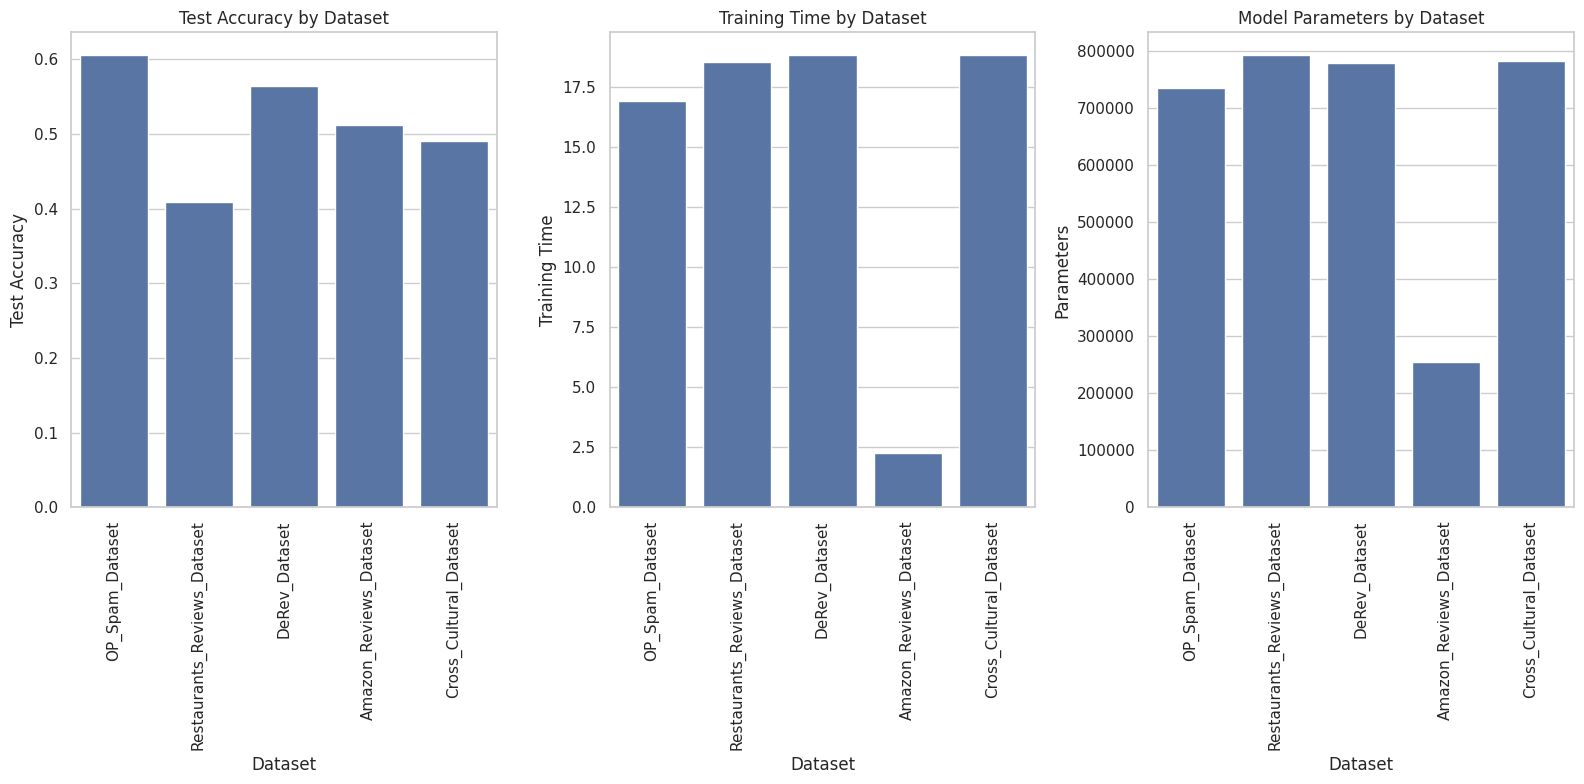

Vocab()

Model:
TransformerModel(
  (embedding): Embedding(7032, 100)
  (attention): SelfAttention(
    (query): Linear(in_features=100, out_features=100, bias=True)
    (key): Linear(in_features=100, out_features=100, bias=True)
    (value): Linear(in_features=100, out_features=100, bias=True)
    (fc_out): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc): Linear(in_features=100, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=2, bias=True)
)
Total parameters:  750194



Epoch: 1


100%|██████████| 652/652 [00:16<00:00, 40.64it/s]


Train Loss : 0.689
Valid Loss : 0.691 Valid Acc  : 0.529
Epoch: 2


100%|██████████| 652/652 [00:16<00:00, 39.29it/s]


Train Loss : 0.669
Valid Loss : 0.693 Valid Acc  : 0.535
Epoch: 3


100%|██████████| 652/652 [00:15<00:00, 41.90it/s]


Train Loss : 0.635
Valid Loss : 0.712 Valid Acc  : 0.547
Epoch: 4


100%|██████████| 652/652 [00:15<00:00, 41.24it/s]


Train Loss : 0.585
Valid Loss : 0.726 Valid Acc  : 0.543
Epoch: 5


100%|██████████| 652/652 [00:15<00:00, 41.79it/s]


Train Loss : 0.518
Valid Loss : 0.816 Valid Acc  : 0.554
Epoch: 6


100%|██████████| 652/652 [00:15<00:00, 41.87it/s]


Train Loss : 0.444
Valid Loss : 0.868 Valid Acc  : 0.573
Epoch: 7


100%|██████████| 652/652 [00:15<00:00, 42.43it/s]


Train Loss : 0.381
Valid Loss : 1.088 Valid Acc  : 0.547
Epoch: 8


100%|██████████| 652/652 [00:15<00:00, 43.01it/s]


Train Loss : 0.330
Valid Loss : 1.163 Valid Acc  : 0.540
Epoch: 9


100%|██████████| 652/652 [00:15<00:00, 42.48it/s]


Train Loss : 0.297
Valid Loss : 1.205 Valid Acc  : 0.550
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.534
Precision (Weighted): 0.534
Recall (Weighted): 0.534
F1-Score (Weighted): 0.534
Balanced Accuracy: 0.534

Classification Report : 
              precision    recall  f1-score   support

           0       0.53      0.56      0.55       800
           1       0.54      0.51      0.52       800

    accuracy                           0.53      1600
   macro avg       0.53      0.53      0.53      1600
weighted avg       0.53      0.53      0.53      1600


Confusion Matrix : 
[[450 350]
 [395 405]]
750194, 15.358527421951294, 0.534375
Vocab()

Model:
TransformerModel(
  (embedding): Embedding(7619, 100)
  (attention): SelfAttention(
    (query): Linear(in_features=100, out_features=100, bias=True)
    (key): Linear(in_features=100, out_features=100, bias=True)
    (value): Linear(in_features=100, out_features=100, bias=True)
    (fc_out): Linear(in_feat

100%|██████████| 696/696 [00:16<00:00, 41.49it/s]


Train Loss : 0.686
Valid Loss : 0.676 Valid Acc  : 0.552
Epoch: 2


100%|██████████| 696/696 [00:17<00:00, 40.92it/s]


Train Loss : 0.660
Valid Loss : 0.666 Valid Acc  : 0.588
Epoch: 3


100%|██████████| 696/696 [00:17<00:00, 40.31it/s]


Train Loss : 0.621
Valid Loss : 0.693 Valid Acc  : 0.597
Epoch: 4


100%|██████████| 696/696 [00:16<00:00, 41.61it/s]


Train Loss : 0.563
Valid Loss : 0.707 Valid Acc  : 0.594
Epoch: 5


100%|██████████| 696/696 [00:16<00:00, 42.34it/s]


Train Loss : 0.497
Valid Loss : 0.804 Valid Acc  : 0.596
Epoch: 6


100%|██████████| 696/696 [00:16<00:00, 42.03it/s]


Train Loss : 0.428
Valid Loss : 0.820 Valid Acc  : 0.603
Epoch: 7


100%|██████████| 696/696 [00:16<00:00, 41.77it/s]


Train Loss : 0.368
Valid Loss : 0.945 Valid Acc  : 0.596
Epoch: 8


100%|██████████| 696/696 [00:16<00:00, 41.49it/s]


Train Loss : 0.323
Valid Loss : 1.083 Valid Acc  : 0.586
Epoch: 9


100%|██████████| 696/696 [00:16<00:00, 41.69it/s]


Train Loss : 0.293
Valid Loss : 1.207 Valid Acc  : 0.595
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.391
Precision (Weighted): 0.391
Recall (Weighted): 0.391
F1-Score (Weighted): 0.391
Balanced Accuracy: 0.391

Classification Report : 
              precision    recall  f1-score   support

           0       0.39      0.40      0.40        55
           1       0.39      0.38      0.39        55

    accuracy                           0.39       110
   macro avg       0.39      0.39      0.39       110
weighted avg       0.39      0.39      0.39       110


Confusion Matrix : 
[[22 33]
 [34 21]]
808894, 16.701584100723267, 0.39090909090909093
Vocab()

Model:
TransformerModel(
  (embedding): Embedding(7471, 100)
  (attention): SelfAttention(
    (query): Linear(in_features=100, out_features=100, bias=True)
    (key): Linear(in_features=100, out_features=100, bias=True)
    (value): Linear(in_features=100, out_features=100, bias=True)
    (fc_out): Linear(

100%|██████████| 693/693 [00:17<00:00, 39.16it/s]


Train Loss : 0.687
Valid Loss : 0.680 Valid Acc  : 0.557
Epoch: 2


100%|██████████| 693/693 [00:17<00:00, 40.72it/s]


Train Loss : 0.667
Valid Loss : 0.669 Valid Acc  : 0.587
Epoch: 3


100%|██████████| 693/693 [00:16<00:00, 42.34it/s]


Train Loss : 0.635
Valid Loss : 0.670 Valid Acc  : 0.592
Epoch: 4


100%|██████████| 693/693 [00:16<00:00, 42.18it/s]


Train Loss : 0.585
Valid Loss : 0.707 Valid Acc  : 0.592
Epoch: 5


100%|██████████| 693/693 [00:16<00:00, 42.36it/s]


Train Loss : 0.520
Valid Loss : 0.754 Valid Acc  : 0.575
Epoch: 6


100%|██████████| 693/693 [00:16<00:00, 42.02it/s]


Train Loss : 0.449
Valid Loss : 0.784 Valid Acc  : 0.586
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.525
Precision (Weighted): 0.525
Recall (Weighted): 0.525
F1-Score (Weighted): 0.525
Balanced Accuracy: 0.525

Classification Report : 
              precision    recall  f1-score   support

           0       0.52      0.55      0.54       118
           1       0.53      0.50      0.51       118

    accuracy                           0.53       236
   macro avg       0.53      0.53      0.53       236
weighted avg       0.53      0.53      0.53       236


Confusion Matrix : 
[[65 53]
 [59 59]]
794094, 16.5010404586792, 0.5254237288135594
Vocab()

Model:
TransformerModel(
  (embedding): Embedding(2230, 100)
  (attention): SelfAttention(
    (query): Linear(in_features=100, out_features=100, bias=True)
    (key): Linear(in_features=100, out_features=100, bias=True)
    (value): Linear(in_features=100, out_features=100, bias=True)
    (fc_out): Linear(in_

100%|██████████| 76/76 [00:01<00:00, 50.76it/s]


Train Loss : 0.668
Valid Loss : 0.612 Valid Acc  : 0.664
Epoch: 2


100%|██████████| 76/76 [00:01<00:00, 52.48it/s]


Train Loss : 0.599
Valid Loss : 0.623 Valid Acc  : 0.648
Epoch: 3


100%|██████████| 76/76 [00:01<00:00, 41.34it/s]


Train Loss : 0.510
Valid Loss : 0.620 Valid Acc  : 0.680
Epoch: 4


100%|██████████| 76/76 [00:02<00:00, 34.75it/s]


Train Loss : 0.418
Valid Loss : 0.658 Valid Acc  : 0.680
Epoch: 5


100%|██████████| 76/76 [00:02<00:00, 37.44it/s]


Train Loss : 0.334
Valid Loss : 0.754 Valid Acc  : 0.664
Epoch: 6


100%|██████████| 76/76 [00:01<00:00, 52.41it/s]


Train Loss : 0.263
Valid Loss : 0.871 Valid Acc  : 0.656
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.519
Precision (Weighted): 0.524
Recall (Weighted): 0.519
F1-Score (Weighted): 0.496
Balanced Accuracy: 0.519

Classification Report : 
              precision    recall  f1-score   support

           0       0.51      0.73      0.60     10500
           1       0.53      0.30      0.39     10500

    accuracy                           0.52     21000
   macro avg       0.52      0.52      0.50     21000
weighted avg       0.52      0.52      0.50     21000


Confusion Matrix : 
[[7711 2789]
 [7306 3194]]
269994, 1.455371379852295, 0.5192857142857142
Vocab()

Model:
TransformerModel(
  (embedding): Embedding(7519, 100)
  (attention): SelfAttention(
    (query): Linear(in_features=100, out_features=100, bias=True)
    (key): Linear(in_features=100, out_features=100, bias=True)
    (value): Linear(in_features=100, out_features=100, bias=True)
    (fc_out): L

100%|██████████| 682/682 [00:16<00:00, 41.46it/s]


Train Loss : 0.687
Valid Loss : 0.686 Valid Acc  : 0.537
Epoch: 2


100%|██████████| 682/682 [00:16<00:00, 41.74it/s]


Train Loss : 0.667
Valid Loss : 0.686 Valid Acc  : 0.576
Epoch: 3


100%|██████████| 682/682 [00:16<00:00, 41.97it/s]


Train Loss : 0.627
Valid Loss : 0.683 Valid Acc  : 0.581
Epoch: 4


100%|██████████| 682/682 [00:16<00:00, 41.18it/s]


Train Loss : 0.577
Valid Loss : 0.714 Valid Acc  : 0.583
Epoch: 5


100%|██████████| 682/682 [00:16<00:00, 41.23it/s]


Train Loss : 0.508
Valid Loss : 0.764 Valid Acc  : 0.582
Epoch: 6


100%|██████████| 682/682 [00:16<00:00, 41.89it/s]


Train Loss : 0.436
Valid Loss : 0.811 Valid Acc  : 0.578
Epoch: 7


100%|██████████| 682/682 [00:16<00:00, 41.58it/s]


Train Loss : 0.374
Valid Loss : 0.931 Valid Acc  : 0.569
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.487
Precision (Weighted): 0.486
Recall (Weighted): 0.487
F1-Score (Weighted): 0.485
Balanced Accuracy: 0.487

Classification Report : 
              precision    recall  f1-score   support

           0       0.48      0.43      0.46       301
           1       0.49      0.54      0.51       303

    accuracy                           0.49       604
   macro avg       0.49      0.49      0.49       604
weighted avg       0.49      0.49      0.49       604


Confusion Matrix : 
[[130 171]
 [139 164]]
798894, 16.40705442428589, 0.4867549668874172

Results DataFrame for Transformer Model:
                       Dataset  Parameters  Training Time  Test Accuracy  \
0              OP_Spam_Dataset      750194      15.358527       0.534375   
1  Restaurants_Reviews_Dataset      808894      16.701584       0.390909   
2                DeRev_Dataset      794094   

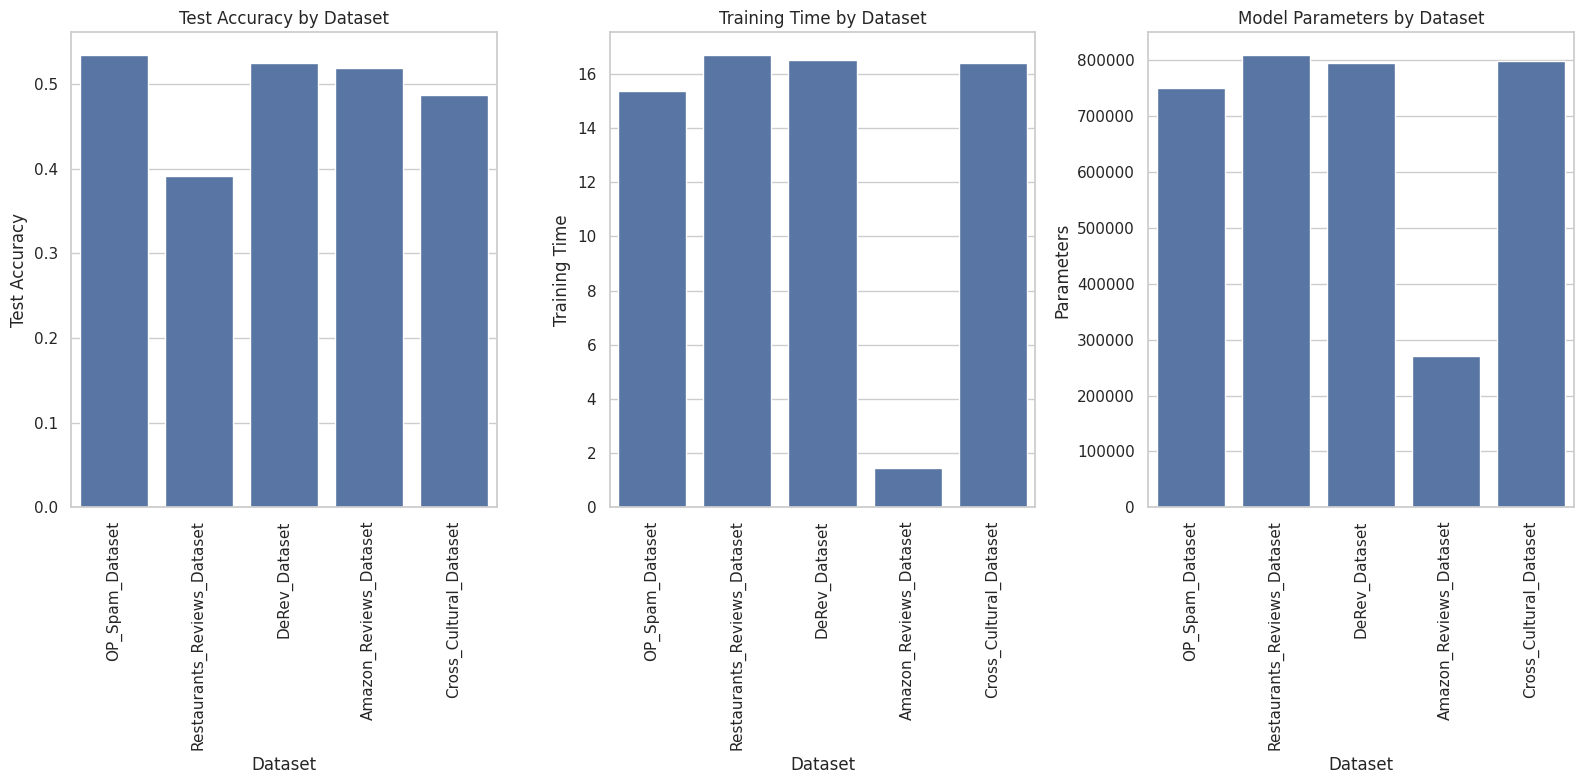

In [ ]:
birnn_results_df = run_experiment(datasets_loaders, BiRNNModel, "BiRNN Model", 3, False)
lstm_results_df = run_experiment(datasets_loaders, LSTMModel, "LSTM Model", 3, False)
gru_results_df = run_experiment(datasets_loaders, GRUModel, "GRU Model", 3, False)
transformer_results_df= run_experiment(datasets_loaders, TransformerModel, "Transformer Model", 3, True)

In [ ]:
import pandas as pd

# Add a 'Model' column to each DataFrame
rnn_results_df['Model'] = 'RNN Model'
birnn_results_df['Model'] = 'BiRNN Model'
lstm_results_df['Model'] = 'LSTM Model'
gru_results_df['Model'] = 'GRU Model'
transformer_results_df['Model'] = 'Transformer Model'

# List of DataFrames to concatenate
dataframes = [rnn_results_df, birnn_results_df, lstm_results_df, gru_results_df, transformer_results_df]

# Concatenate the DataFrames along rows (axis=0)
combined_results_df = pd.concat(dataframes, axis=0, ignore_index=True)

# Print the combined DataFrame to verify
print(combined_results_df)


                        Dataset  Parameters  Training Time  Test Accuracy  \
0               OP_Spam_Dataset      713954       9.032176       0.475625   
1   Restaurants_Reviews_Dataset      772654      10.396361       0.500000   
2                 DeRev_Dataset      757854      10.631714       0.495763   
3        Amazon_Reviews_Dataset      233754       0.917175       0.491333   
4        Cross_Cultural_Dataset      762654      11.108832       0.506623   
5               OP_Spam_Dataset      724706      14.134169       0.478125   
6   Restaurants_Reviews_Dataset      783406      15.373577       0.445455   
7                 DeRev_Dataset      768606      15.837421       0.563559   
8        Amazon_Reviews_Dataset      244506       1.857526       0.496476   
9        Cross_Cultural_Dataset      773406      15.012075       0.518212   
10              OP_Spam_Dataset      745826      13.318456       0.538750   
11  Restaurants_Reviews_Dataset      804526      14.016703       0.427273   

In [ ]:
combined_results_df.to_csv('cross_domain_full_results.csv')